# Détectez des faux billets avec Python

## Importation des bibliotheques et des jeux de donnés

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab
import pickle

#Régression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utilisation du pca, cluster
from sklearn.decomposition import PCA
from fonctions import *
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
billets = pd.read_csv('billets.csv', sep = ';') # Donnée de test

### Lecture des donnés

In [3]:
print(billets.shape)
#billets.head(50)

(1500, 7)


In [4]:
billets.info()
billets.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [5]:
#Valeur manquante.
print(billets.isnull().sum(axis = 0))

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


##### Observation:
* Il y à 37 valeurs manquantes sur la variable margin_low, soit environs 2.5%. Nous allons utiliser une regression linéaire pour combler les informations manquantes.

In [6]:
billets_full = billets.dropna() # Récupération des individus avec les données complétes.
billets_nan = billets[billets.isnull().any(axis=1)] # Récupération des individus avec les données manquantes.

##### Colinéarité des varaibles

In [7]:
X = billets_full.iloc[:, 1:] # Exclure "is_genuine"

In [8]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

        feature            VIF
0      diagonal  170808.246898
1   height_left  114373.426488
2  height_right  105157.499668
3    margin_low      89.003990
4     margin_up     264.908266
5        length   31205.638468


##### Observation : 
* D'après le vif, la diagonal, height_right et height_left sont corrélé

## Matrice de corrélation

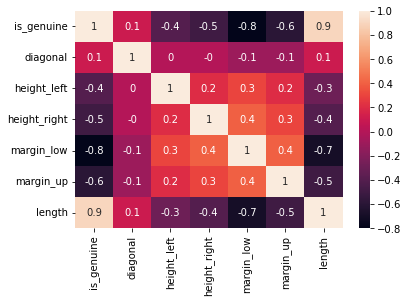

In [9]:
matrice_corr = billets_full.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)
plt.savefig('matrice_corr.png')

##### Observation:
* D'après la matrice de corrélation, nous pouvons voir que "margin_low" et fortement corrélé négativement à "length".
Nous allons donc utiliser "length" pour prédire "margin_low".

## Régression linéaire simple

* La régression linéaire simple est une approche pour prédire une réponse à l’ aide d’une seule caractéristique .

#### Préparation des données

In [10]:
X = billets_full[ "length"]
#X = billets_full.drop(columns=["margin_low"])
y = billets_full['margin_low']

In [11]:
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

In [12]:
# Fractionner la base de données en test et entrainement stra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1170, 1)
(293, 1)
(1170, 1)
(293, 1)


#### Modèle regression linéaire

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Evaluation de notre modèle test

In [14]:
#Prédiction test
y_test_predict = lr.predict(X_test)

In [15]:
R2 = r2_score(y_test, y_test_predict).round(2)
coef = (lr.coef_).round(2)

# Affichage des valeurs de l'évaluation
print("La performance du Modèle pour le set de Test")
print("------------------------------------------------")
print("le score R2 est {}".format(R2))
print("Le coéfficien de la pente {}".format(coef))
print("\n")

La performance du Modèle pour le set de Test
------------------------------------------------
le score R2 est 0.49
Le coéfficien de la pente [[-0.49]]




##### Observation:
* R² explique dans quelle mesure la variance d’une variable explique la variance de la seconde variable. Il est compris entre 0 et 1.
* Le R²(Coéfficien de détermination) est de 0.49, la moitié de la variation observée peut être expliquée par les entrées du modèles.
* Le coéfficien de la pente nous indique que pour chaque mm en plus sur la longueur on ajoute -0.49 a la marge du bas. Plus le billets et long plus la marge bas est reduite

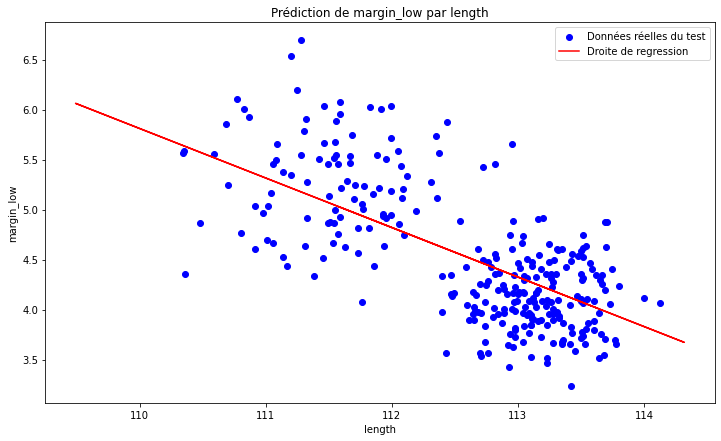

In [16]:
fig = plt.figure(figsize=(12, 7))
plt.scatter(X_test, y_test, color = "b", label = "Données réelles du test")
plt.plot(X_train, lr.predict(X_train), color = "r", label= "Droite de regression")
plt.title("Prédiction de margin_low par length")
plt.xlabel("length")
plt.ylabel("margin_low")
plt.legend()
plt.savefig('regression_droite.png')
plt.show();

##### Normalité des résidus

In [17]:
billets_residus = billets_full

In [18]:
billets_residus["prediction_margin_low"] = lr.predict(X)

In [19]:
#Création d'une colonné résidus (différence entre valeur reel et prédict)
billets_residus["residus"] = billets_residus["margin_low"] - billets_residus["prediction_margin_low"]

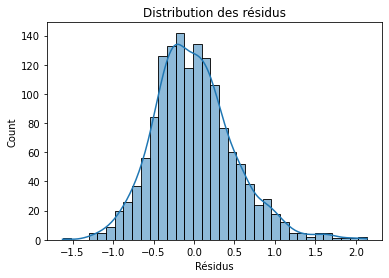

In [20]:
# Histogramme
sns.histplot(billets_residus["residus"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Count")
plt.title("Distribution des résidus")
plt.savefig('résidus.png')
plt.show()

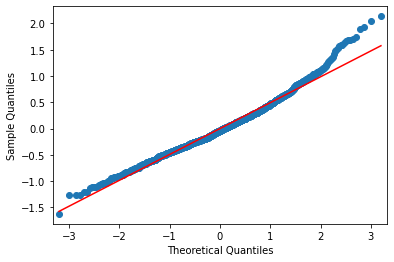

In [21]:
# QQ Plot
sm.qqplot(billets_residus["residus"], line='r')
plt.savefig('résidus.png')
pylab.show()

##### Observation : 
* L'histogrammes ainsi QQ Plot nous montre une distribution normal des résidus.

##### Homoscédasticité

* Désigne la propriété de certains modèles de régression linéaire dans lesquels les erreurs d'estimation sont constantes tout au long des observations.

{'Test Statistic': 109.86015196865361, 'p-value': 2.082824498986684e-14, 'F-Statistic': 5.853731207800802, 'F-Test p-value': 4.9748650927224264e-15}


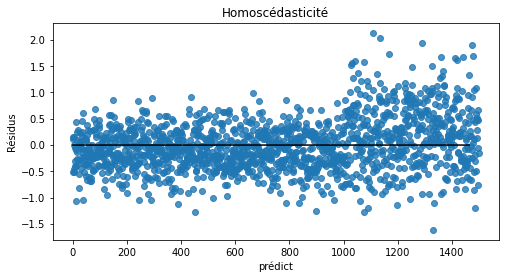

In [22]:
from statsmodels.stats.diagnostic import het_white , normal_ad
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
# Instanciation:
fit = smf.ols("margin_low ~ height_right + height_left + margin_up + length + diagonal", data =billets_full).fit()

# Homoscedasticite:
white_test = het_white(fit.resid, fit.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=billets_full.index, y=billets_full["residus"], alpha=0.8)
plt.plot(np.repeat(0, len(billets_full.index)+2), color="black", linestyle='-')
plt.xlabel("prédict")
plt.ylabel("Résidus")
plt.title("Homoscédasticité")
plt.savefig('Homoscédasticité.png')

##### Observation :
* Les points de données sont égalements dispersés, il y a donc homoscédasticité.

###### Le test de White utilise les hypothèses nulles et alternatives suivantes :

* Null (H 0 ) : L'homoscédasticité est présente (les résidus sont également dispersés) Si p < 0.5
* Alternative (H A ) : l'hétéroscédasticité est présente (les résidus ne sont pas également dispersés) Si p > 0.5

* p étant inférieure a 0.5 l'homoscédasticité est doc présente.

##### Conclusion
* Distribution gaussienne des résidus
* Homoscedasticité des résidus (i.e. les résidus ont la même variance quel que soit le groupe considéré, ou quelle que soit la valeur de la variable explicative considérée)

### Application du modèle à notre jeu de donnée avec des valeurs manquantes.

#### Application du modele sur les donnees manquantes

In [23]:
X_test = billets_nan[["length"]]
#X_test = billets_nan.drop(columns=["margin_low"])
billets_nan["margin_low"] = lr.predict(X_test.values)

In [24]:
X_test = billets[["length"]]
#X_test = billets.drop(columns=["margin_low"])
billets["prediction_margin_low"] = lr.predict(X_test.values)

In [25]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_margin_low
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000,1500.000000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850,4.484066
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273,0.431969
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000,3.612189
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000,4.156648
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000,4.344734
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000,4.805049
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000,6.062255


##### Observation : 
* Avant prédiction la moyenne de margin low = 4.485967 après prédiction 4.484066
* La moyenne de margin_low n'est pas inpacté suite par la prédiction.

In [26]:
billets = pd.concat([billets_full, billets_nan])

In [27]:
# Suppression de la colonne résidus
billets.drop(columns=["residus", "prediction_margin_low"],inplace=True)

In [28]:
billets.to_csv('billets_clean.csv',index=False)

## Analyse descriptive

### Information sur les données

In [29]:
billets = pd.read_csv('billets_clean.csv') # Donnée de test

In [30]:
billets_true = billets[billets['is_genuine'] == True]
billets_false = billets[billets['is_genuine'] == False]

In [31]:
#Describe sur les billets_true
billets_true.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.119550,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.317464,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.910000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.120000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.342421,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [32]:
#Describe sur les billets_false
billets_false.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.213241,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.550860,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.180000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.590000,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [33]:
#billets.info()
#billets.describe()

In [34]:
billets.head(1)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83


### Nombre de vrais / faux billets

            Total
is_genuine       
False         500
True         1000


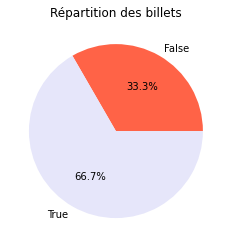

In [35]:
# Regrouper les billets par vrais / faux, et compte le total
print(billets.groupby('is_genuine').agg(Total = ('length', 'count')))

# Affichage du % de vrais / faux à l'aide des graphique pie:
fig, ax = plt.subplots()
ax.pie(billets.groupby(["is_genuine"])["length"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",
        colors=['tomato','lavender'])
plt.title("Répartition des billets")
plt.savefig('pie.png')
plt.show()

##### Observation:
* Nous avons donc 66.7% de billets true et 33.3% de billets false

### Répartition des dimensions des billets

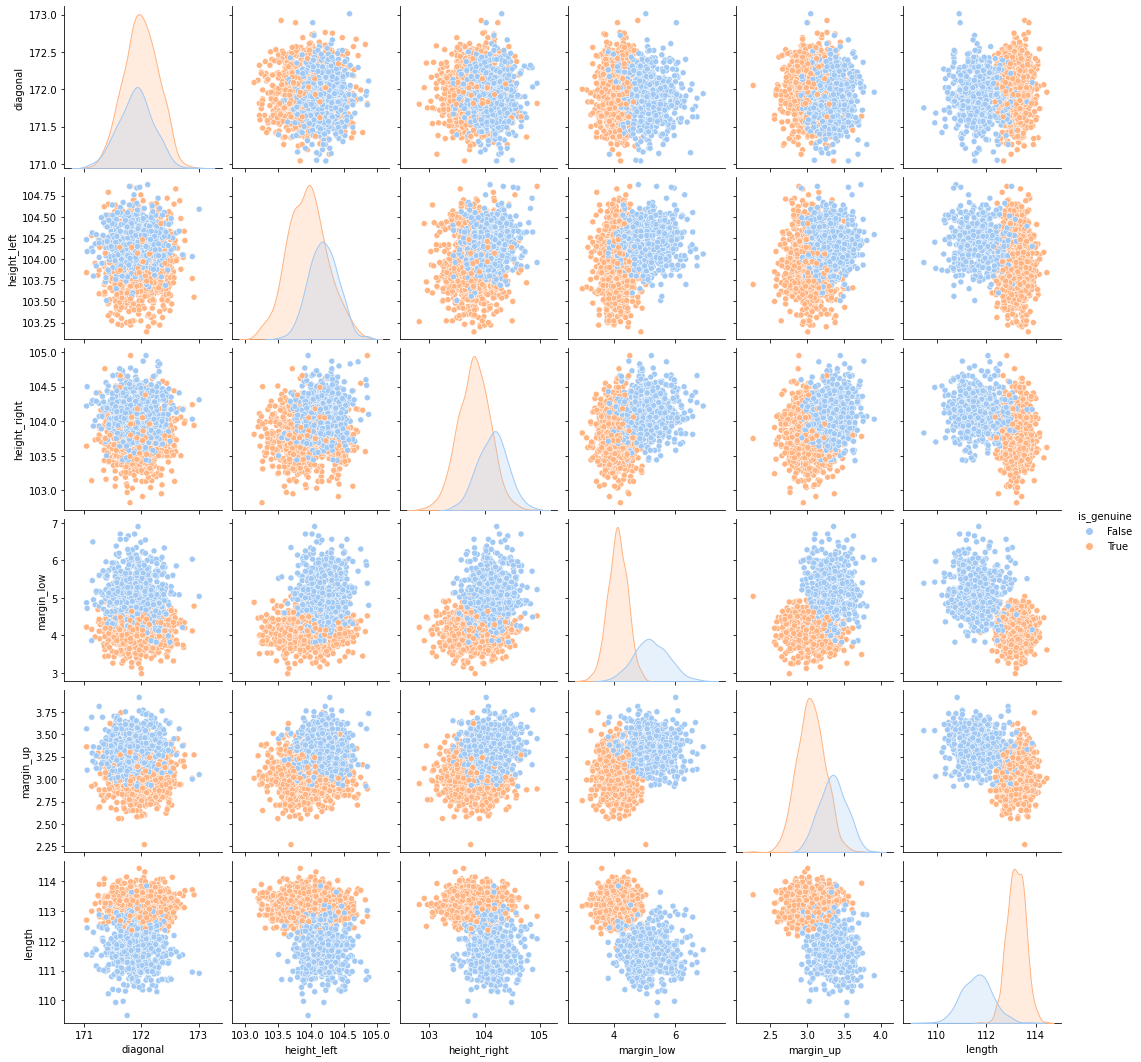

In [36]:
# Répartition des billets en fonctions de leurs 6 variables (dimensions)
sns.pairplot(billets, hue="is_genuine", palette="pastel")
plt.savefig('repartition.png')

##### Observation :
* On constate que les vrai et faux billets sont très distingué les uns par rapport au autres.

### Analyse composante principale

In [37]:
X = billets.select_dtypes('number') #Récupération des valeurs
print('X', X.shape)

X (1500, 6)


In [38]:
y = billets.is_genuine #Sauvegarde si vrai ou faux
print('y', y.shape)

y (1500,)


In [39]:
num_components = 6
pca = PCA(n_components=num_components)
pca.fit(X)

PCA(n_components=6)

#### Tableau de variance

In [40]:
# Donnée expliqué en fonction du nombre de composantes principales retenue
pca = decomposition.PCA(n_components = num_components)
pca.fit(X)
tableau_variance = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(num_components)], 
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
tableau_variance

,Dimension,% cum. var. expliquée
0,Dim1,69.0
1,Dim2,81.0
2,Dim3,87.0
3,Dim4,93.0
4,Dim5,98.0
5,Dim6,100.0


##### Observation:
* Nous pouvoir voir que sur les 6 variables, 3 explique 87% des données.
* Nous pouvons donc envisager d'utiliser 3 varaibles.

##### Analyse des resultats

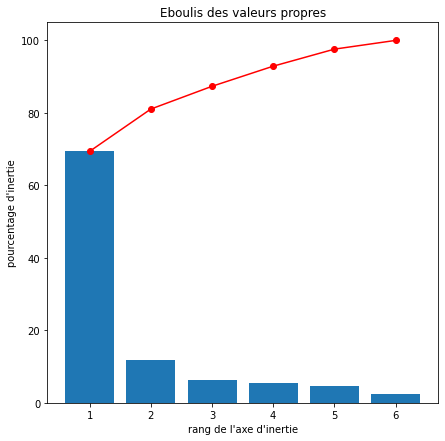

In [41]:
#Courbe d'eboulis
fig = plt.figure(figsize=(7, 7))
display_scree_plot(pca)

##### Cercle de corrélation

<Figure size 720x720 with 0 Axes>

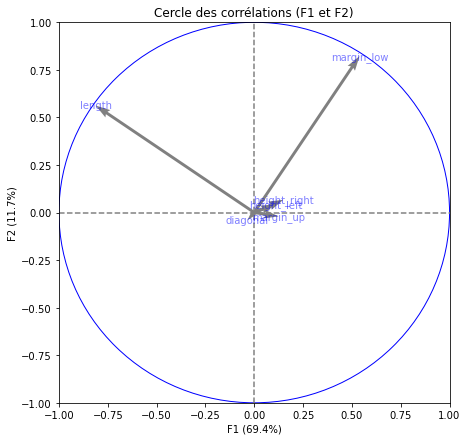

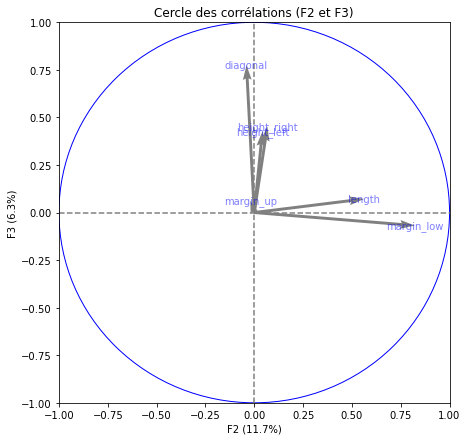

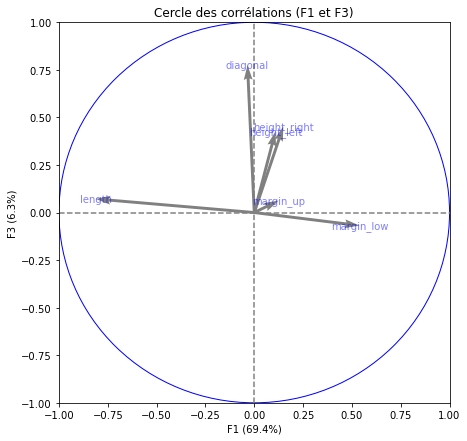

In [42]:
pcs = pca.components_ 
fig = plt.figure(figsize=(10, 10))
display_circles(pcs, num_components, pca, [(0,1), (1,2), (0,2)], labels = np.array(X.columns))

##### Observation:
* Nous pouvons voir par les cercles de corrélation que les 3 variables principales sont "length", "margin_low" et "diagonal"
* Malgré que 3 variables devraient etre suffisantes pour déterminer si un billet est vrais ou faux, nous utiliserons les 6 variables. En effet nous pouvons partir du principe qu'un billet n'est pas forcement en très bonne état.

In [43]:
# Exclure la colonne "is_genuine"
billets_pca = billets.iloc[:, 1:]

## Utilisation Kmeans pour visualiser les billets vrai et faux

In [44]:
#Récupération des données
X = billets_pca

C:\Users\frederic.vella\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


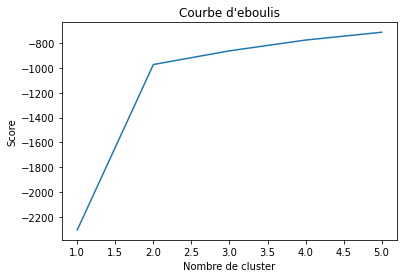

In [45]:
# Lance 10 fois le teste et garde la meilleure solution
num_clusters = 6
kmeans_tests = [KMeans(n_clusters=i, init='k-means++', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(X).score(X) for i in range(len(kmeans_tests))]

# Affiche la courbe d'eboulis
plt.plot(range(1, num_clusters),score)
plt.xlabel('Nombre de cluster')
plt.ylabel('Score')
plt.title('Courbe d\'eboulis')
plt.show()

##### Observation:
* La courbe d'eboulis nous permet de voir qu'il existe potentiellement 2 clusters.

### Clusters

In [46]:
# Création du model de clustering k-means pour 2 clusters
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10, random_state=40)
# Ajuste les données au model
kmeans.fit(X)
# Determine le cluster de chaque individu
clusters =  kmeans.predict(X)

In [47]:
# Ajoute le numéros du cluster aux donénes
X_clustered = pd.DataFrame(X, columns=X.columns, index=X.index).round(2)
X_clustered['cluster'] = clusters
#X_clustered.head()

In [48]:
# Determine la taille des clusters
X_clustered["cluster"].value_counts()

1    1016
0     484
Name: cluster, dtype: int64

##### Observation:
* Rappel dans nos donnée il y a 1000 vrais billets et 500 faux.
* Avec kmeans nous avons +1% de faux positif.

In [49]:
# Création d'un model PCA à 2 dimensions pour afficher nos données sur 2 dimensions
pca = PCA(n_components=2)
pca.fit(X)
# Transfere les données sur le nouveau PCA 2D
X_reduced = pca.transform(X)

In [50]:
# Convertion des résultats en dataframe
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
#X_reduceddf.head()

In [51]:
centres_reduced = pca.transform(kmeans.cluster_centers_)
X_trans = pca.transform(X)

C:\Users\frederic.vella\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


### Comparaison entre les 2 clusters et les vrai et faux billets

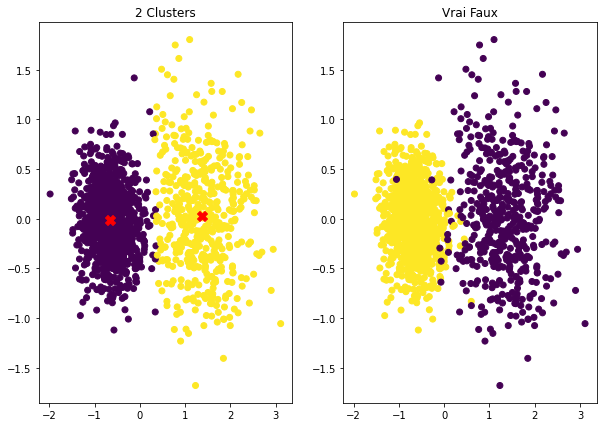

In [52]:
fig = plt.figure(figsize=(10,7))
cls2 = cluster.KMeans(n_clusters=2)
cls2.fit(X)
ax = fig.add_subplot(121)
plt.title('2 Clusters')
ax.scatter(X_trans[:,0], X_trans[:, 1], c=cls2.labels_)
plt.scatter(centres_reduced[:,0],centres_reduced[:,1],s = 100, c = 'r',marker = 'X')
plt.savefig('cluster.png')

ax = fig.add_subplot(122)
plt.title('Vrai Faux')
ax.scatter(X_trans[:,0], X_trans[:, 1], c=y)
plt.savefig('truenfalse.png')

##### Observation :
* Nous remarquons que les 2 Clusters sont quasi similaire aux vrai, faux billets.

### Comparaison entre les clusters et les donnée originel de faut et vrai billets

In [53]:
#Cluster Kmeans
cluster_k = X_clustered.groupby(['cluster']).mean()
print(cluster_k.shape)
cluster_k.head()

(2, 6)


,diagonal,height_left,height_right,margin_low,margin_up,length
cluster,,,,,,
0,171.898492,104.193017,104.144855,5.236880,3.347231,111.591860
1,171.986998,103.951654,103.813337,4.125502,3.058219,113.196152


In [54]:
billets_save = billets

In [55]:
#Heatmap avec Kmeans
cluster_df = billets_save.groupby(['is_genuine']).mean()
print(cluster_df.shape)
cluster_df.head()

(2, 6)


,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,5.213241,3.35016,111.63064
True,171.98708,103.94913,103.80865,4.119550,3.05213,113.20243


##### Observation :
* Nous pouvons voir que grace aux moyennes que le cluster 1 correspondre au vrais billets.

In [56]:
billets_save.to_csv('billets_save.csv', index = False)

## Régression logistic

* La régression logistique est un modèle statistique permettant d’étudier les relations entre un ensemble de variables qualitatives Xi et une variable qualitative Y. Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien. 

#### Récupération des données

In [57]:
billets = pd.read_csv('billets_save.csv') # Donnée de test
billets_test = pd.read_csv('billets_production.csv', sep = ',') #Donnée à tester

In [58]:
#billets['Probabilité_vrai'] = 0
#billets_test['Probabilité_vrai'] = 0

In [59]:
# Utilisation de la colonne ID en tant que ID
billets_test.set_index('id', inplace=True)
print(billets_test.shape)

(5, 6)


#### Préparation des données

In [60]:
X = billets.iloc[:, 1:] # Exclure "is_genuine"
y = billets.iloc[:,:1] # Garde uniquement "is_genuine"
print(X.shape)
print(y.shape)

(1500, 6)
(1500, 1)


##### Fractionnement en données de test et train 80% 20%

In [61]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
for train, test in sss.split(X, y):
    X_train, X_test=X.iloc[train], X.iloc[test]
    y_train, y_test=y.iloc[train], y.iloc[test]
    
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1200, 6)
(300, 6)
(1200, 1)
(300, 1)


In [62]:
# Test du model de regression logistic
models={
    'LogisticRegression':LogisticRegression(random_state = 0),
}

# Fonction de précision
def accu(y_true, y_pred, retu = False):
    acc = accuracy_score(y_true, y_pred)
    if retu:
        return acc
    else:
        print(f'Précision du modèle est de :{acc}')

# Fonction d'application des modèles
def train_test_eval(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(name, ':')
        model.fit(X_train, y_train)
        accu(y_test, model.predict(X_test))
        
train_test_eval(models, X_train, y_train, X_test, y_test)

LogisticRegression :
Précision du modèle est de :0.9933333333333333


C:\Users\frederic.vella\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### Observation:
* On peu voir que notre modèle de regression logistic est proche de 100%

#### Modélisation et lecture des résultats

In [63]:
# Application de la regression logistique sur notre base de données
logr = LogisticRegression()
logr.fit(X,y)

C:\Users\frederic.vella\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

#### Evaluation donnée test

In [64]:
#Nombre de vrais et faux billet dans le test
#y_test.groupby(['is_genuine']).size()

##### Matrice de confusion sur la prédiction

In [65]:
predBrut = logr.predict(X_test)
print(np.unique(predBrut, return_counts=True))

(array([False,  True]), array([ 98, 202], dtype=int64))


In [66]:
print(metrics.confusion_matrix(y_test, predBrut))

[[ 98   2]
 [  0 200]]


##### Observation:
* Le résultat nous dit que nous avons 98 + 200 prédictions correctes et 2 + 0 prédictions erronées.

##### Coefficient

In [67]:
log_odds = logr.coef_[0]
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

,coef
length,3.904130
diagonal,-0.162308
height_left,-1.597507
height_right,-2.087178
margin_up,-3.451579
margin_low,-3.646923


##### Observation :
* Les coefficients de régression logistique représentent la probabilité logarithmique qu'une observation soit dans la classe cible compte tenu des valeurs de ses variables X. Ainsi, ces coefficients log doivent être convertis en cotes régulières afin de leur donner un sens.

In [68]:
cotes = np.exp(logr.coef_[0]) 
pd.DataFrame(cotes, 
             X.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

,coef
length,49.606905
diagonal,0.850179
height_left,0.202400
height_right,0.124037
margin_up,0.031696
margin_low,0.026071


##### Observation :
* Pour chaque augmentation d'une unité de [variable X], les chances que l'observation soit dans (classe y) sont [coefficient] fois plus grandes que les chances que l'observation ne soit pas dans (classe y) lorsque toutes les autres variables sont conservées constant."
* Ainsi, à mesure que la variable "length" augmente d'une unité, les chances que les billets représentées dans l'observation soient dans la classe cible sont plus de 49 fois plus elevé que les chances qu'elles ne le soient pas. être dans la classe cible.
* Enfin nous pouvons contacter que "length" est la variable qui a le plus de poids dans la detection de faux billets.

##### Classification report

In [69]:
print(metrics.classification_report(y_test, predBrut))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       100
        True       0.99      1.00      1.00       200

    accuracy                           0.99       300
   macro avg       1.00      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



##### Observation:
* Accuracy: Pourcentage de prédictions correctes
* Precision: Corriger les prédictions positives par rapport au total des prédictions positives
* Recall:  Corriger les prédictions positives par rapport au total des positifs réels
* Au vu des résultat nous pouvons en déduire que notre modéle de régression linéaire est quasi parfait.

##### Courbe de ROC

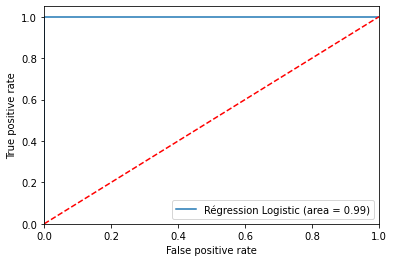

In [70]:
logit_roc_auc = roc_auc_score(y_test, logr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Régression Logistic (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('')
plt.legend(loc='lower right')
plt.savefig('courbe_roc.png')
plt.show()                              

##### Observation:
* Si le TPR est proche de 1, nous avons un très bon modèle. Le modèle est capable de distinguer correctement les résultats positifs et négatifs.
* Si le TPR est de 0,5, cela montre que le modèle est aussi bon qu'une supposition.
* Si le TPR est inférieur à 0,5, cela indique que le modèle prédit des valeurs positives comme négatives et des valeurs négatives comme positives.

##### Matrice de confusion sur l'ensemble des donnée

In [71]:
predBrut = logr.predict(X)
print(np.unique(predBrut, return_counts=True))

(array([False,  True]), array([ 497, 1003], dtype=int64))


In [72]:
print(metrics.confusion_matrix(y, predBrut))

[[491   9]
 [  6 994]]


##### Observation : 
* * Le résultat nous dit que nous avons 491 + 994 prédictions correctes et 9 + 6 prédictions erronées.

##### Visualisation des prédiction et probabilité sur les données base.

In [73]:
billets_predict = billets.iloc[:, 1:] # Exclure "is_genuine"
billets["prediction"] = logr.predict(billets_predict.values)

C:\Users\frederic.vella\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [74]:
billets["Probabilité_vrai"] = ((logr.predict_proba(billets_predict)[:,1])*100).round(2)

In [75]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,Probabilité_vrai
0,True,171.81,104.86,104.95,4.52,2.89,112.83,False,39.49
1,True,171.46,103.36,103.66,3.77,2.99,113.09,True,99.97
2,True,172.69,104.48,103.50,4.40,2.94,113.16,True,99.02
3,True,171.36,103.91,103.94,3.62,3.01,113.51,True,99.98
4,True,171.73,104.28,103.46,4.04,3.48,112.54,True,90.06


#### Application du modéle sur les données à tester

In [76]:
#billets_test.head()

In [77]:
billets_test_predict = billets_test
billets_test["prediction"] = logr.predict(billets_test_predict.values)

C:\Users\frederic.vella\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [78]:
billets_test_proba = billets_test.drop(columns=["prediction"])

In [79]:
billets_test["Probabilité_vrai"] = ((logr.predict_proba(billets_test_proba)[:,1])*100).round(2)

In [80]:
billets_test.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,Probabilité_vrai
id,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,False,0.39
A_2,171.87,104.17,104.13,6.00,3.31,112.09,False,0.06
A_3,172.00,104.58,104.29,4.99,3.39,111.57,False,0.09
A_4,172.49,104.55,104.34,4.44,3.03,113.20,True,92.30
A_5,171.65,103.63,103.56,3.77,3.16,113.33,True,99.97


## Sauvegarde du modéle de régression logictic

In [81]:
from joblib import dump, load

dump(logr, 'regression_model_saved.joblib')

['regression_model_saved.joblib']